In [397]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import distance
import re

from cleaning_utils import * # import all existing functions from file cleaning.py

%load_ext autoreload
%autoreload 2


pd.set_option('display.max_columns', 360)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---



## Loading Blight Data

In [398]:
blight = pd.read_csv('../P3_data/Blight_Violations.csv')

/Users/ivan/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (9,11,15,16,17,30) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [399]:
blight.head(3)

,X,Y,ticket_id,ticket_number,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,violator_id,mailing_address_str_number,mailing_address_str_name,city,state,zip_code,non_us_str_code,country,violation_date,ticket_issued_time,hearing_date,hearing_time,judgment_date,violation_code,violation_description,disposition,clean_up_cost,payment_amount,payment_date,payment_status,collection_status,violation_address,parcelno,oid,geom,fine_amount
0,-83.072573,42.383350,18645,05001700DAH,"Buildings, Safety Engineering & Env Department",Orbie Gailes,Dean Byrd,601,KING,NaN,1614,599,King,Det,MI,48202,NaN,NaN,2005/01/13 00:00:00+00,1900/01/01 14:00:00,2005/02/07 00:00:00+00,09:00:00,2005/02/07 00:00:00+00,9-1-36(a),Failure of owner to obtain certificate of comp...,Responsible by Default,NaN,NaN,1970/01/01 00:00:00+00,NaN,NaN,601 KING,03002390.,18645,NaN,NaN
1,-83.072479,42.383394,18646,05001701DAH,"Buildings, Safety Engineering & Env Department",Orbie Gailes,Cynthia Roberts,607,KING,NaN,1615,18604,Appoline,Det,MI,48235,NaN,NaN,2005/01/14 00:00:00+00,1900/01/01 00:45:00,2005/02/14 00:00:00+00,09:00:00,2019/09/16 10:26:00+00,9-1-36(a),Failure of owner to obtain certificate of comp...,Not responsible by City Dismissal,NaN,NaN,1970/01/01 00:00:00+00,NO PAYMENT DUE,NaN,607 KING,03002391.,18646,NaN,NaN
2,-83.115061,42.359916,18648,05001703DAH,"Buildings, Safety Engineering & Env Department",Orbie Gailes,Dannny Barnes,4066,COLUMBUS,NaN,1617,4066,Columbus,Det,MI,48204,NaN,NaN,2005/01/14 00:00:00+00,1900/01/01 14:00:00,2005/02/14 00:00:00+00,09:00:00,2005/02/14 00:00:00+00,9-1-36(a),Failure of owner to obtain certificate of comp...,Not responsible by Dismissal,NaN,NaN,1970/01/01 00:00:00+00,NO PAYMENT DUE,NaN,4066 COLUMBUS,14002572.,18648,NaN,NaN


In [400]:
blight.shape

(496335, 36)

In [401]:
blight.payment_status.value_counts()

NO PAYMENT DUE             210004
PAID IN FULL                97642
PARTIAL PAYMENT APPLIED      9080
NO PAYMENT APPLIED              2
Name: payment_status, dtype: int64

In [402]:
blight = blight[blight.payment_status == 'PAID IN FULL']

In [403]:
blight.columns

Index(['X', 'Y', 'ticket_id', 'ticket_number', 'agency_name', 'inspector_name',
       'violator_name', 'violation_street_number', 'violation_street_name',
       'violation_zip_code', 'violator_id', 'mailing_address_str_number',
       'mailing_address_str_name', 'city', 'state', 'zip_code',
       'non_us_str_code', 'country', 'violation_date', 'ticket_issued_time',
       'hearing_date', 'hearing_time', 'judgment_date', 'violation_code',
       'violation_description', 'disposition', 'clean_up_cost',
       'payment_amount', 'payment_date', 'payment_status', 'collection_status',
       'violation_address', 'parcelno', 'oid', 'geom', 'fine_amount'],
      dtype='object')

In [404]:
# Selecting not important features to drop from DF
columns_to_drop = [
                 'ticket_number',
                 'agency_name',
                 'inspector_name',
                 'violator_name',
                 'violator_id',
                 'mailing_address_str_number',
                 'mailing_address_str_name',
                 'city',
                 'state',
                 'zip_code',
                 'non_us_str_code',
                 'country',
                 'ticket_issued_time',
                 'hearing_date',
                 'hearing_time',
                 'violation_code',
                 'violation_description',
                 'disposition',
                 'clean_up_cost',
                 'payment_amount',
                 'collection_status',
                 'violation_address',
                 'oid',
                 'geom',
                 'fine_amount']

In [405]:
blight = blight.drop(columns=columns_to_drop)

In [406]:
blight.shape

(97642, 11)

-----






## Defining Target Variable Compliance

In [407]:
blight.head()

,X,Y,ticket_id,violation_street_number,violation_street_name,violation_zip_code,violation_date,judgment_date,payment_date,payment_status,parcelno
7,-83.019172,42.339196,18653,2900,JEFFERSON,NaN,2005/01/14 00:00:00+00,2005/02/23 00:00:00+00,2005/02/22 08:43:00+00,PAID IN FULL,11000088.014
11,-82.942097,42.388525,18657,15439,MACK,NaN,2005/01/14 00:00:00+00,2005/02/18 00:00:00+00,2005/03/09 13:33:00+00,PAID IN FULL,21001420.
12,-82.946176,42.371778,18658,14214,JEFFERSON,NaN,2005/01/14 00:00:00+00,2005/02/04 00:00:00+00,2005/02/04 10:19:00+00,PAID IN FULL,21000354.
15,-83.045750,42.335121,18661,1310,BROADWAY,NaN,2005/01/14 00:00:00+00,2005/02/18 00:00:00+00,2007/06/12 00:00:00+00,PAID IN FULL,01004004.
18,-83.044467,42.335210,18664,343,MACOMB,NaN,2005/01/14 00:00:00+00,2005/03/23 00:00:00+00,2007/05/31 00:00:00+00,PAID IN FULL,01000207.


In [408]:
blight.violation_date = pd.to_datetime(blight['violation_date']).dt.date
blight.judgment_date = pd.to_datetime(blight['judgment_date']).dt.date
blight.payment_date = pd.to_datetime(blight['payment_date']).dt.date

In [409]:
blight.rename({'Y':'lat', 'X':'lon', 'parcelno': 'parcel_id'}, axis=1, inplace=True)
blight = blight.dropna(subset=['parcel_id'])
blight['parcel_id'] = blight.apply(parse_parcel,axis=1)

In [410]:
# Create new column compliance - target variable
blight['compliance'] = blight.apply(compliance, axis=1)

In [411]:
blight.compliance.value_counts(normalize= True)

0    0.667435
1    0.332565
Name: compliance, dtype: float64

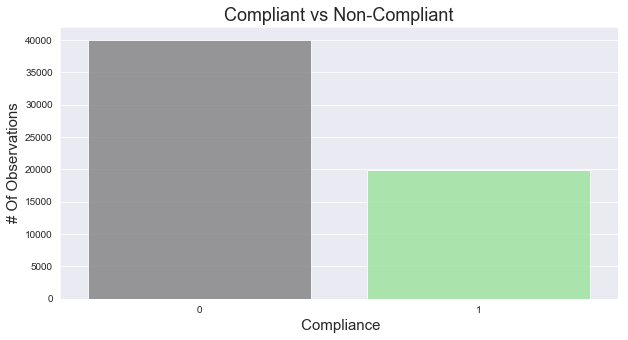

In [412]:
# Target Variable Countplot
sns.set_style('darkgrid')
plt.figure(figsize = (10,5))
sns.countplot(blight['compliance'], alpha =.80, palette= ['grey','lightgreen'])
plt.title('Compliant vs Non-Compliant', size = 18)
plt.ylabel('# Of Observations', size =15)
plt.xlabel(' Compliance', size =15)
plt.show()

In [413]:
# applying function coord_bligth
blight['coordinates'] = blight.apply(coord_bligth,axis=1)

In [414]:
blight.to_csv(r'data/Blight.csv', index = False)

----




## Exploring Crime in Neighborhoods with data Reported_Major_Crimes_2011_to_2014

In [415]:
crimes = pd.read_csv('../P3_data/Reported_Major_Crimes_2011_to_2014.csv')

In [416]:
crimes.head()

,ROWNUM,CATEGORY,OFFENSEDESCRIPTION,STATEOFFENSEFILECLASS,INCIDENTDATE,HOUR,SCA,PRECINCT,NEIGHBORHOOD,CENSUSTRACT,LOCATION,ObjectId
0,1311873,STOLEN VEHICLE,VEHICLE THEFT,24001,2011/01/02 00:00:00+00,0,1103.0,11.0,PERSHING,5066.0,"00 EUREKA/E LANTZ\n(42.4382, -83.0579)",1
1,1311874,AGGRAVATED ASSAULT,AGG/FEL ASSAULT - NON-FAMILY - OTHER WEAPON,13002,2011/01/02 00:00:00+00,11,709.0,7.0,LAFAYETTE PARK,5166.0,"E.LAFAYETTE01800\n(42.3394, -83.0295)",2
2,1311878,LARCENY,"LARCENY - FROM BUILDING (INCLUDES LIBRARY, OFF...",23003,2011/01/02 00:00:00+00,11,1105.0,11.0,OUTER DRIVE VAN DYKE,5051.0,"VANDYKE19900\n(42.4415, -83.0238)",3
3,1311879,LARCENY,LARCENY (OTHER),23007,2011/01/01 00:00:00+00,20,706.0,7.0,CHENE,5188.0,"JOS CAMPAU04100\n(42.3606, -83.0339)",4
4,1311883,STOLEN VEHICLE,VEHICLE THEFT,24001,2011/01/02 00:00:00+00,3,612.0,6.0,WARRENDALE,5457.0,"PIEDMONT06000\n(42.3328, -83.228)",5


In [417]:
crimes = crimes[['LOCATION','CATEGORY','INCIDENTDATE']]

In [418]:
# Using functions extract_lat_crime and extract_long_crime
crimes['lat'] = crimes.LOCATION.map(extract_lat_crime)
crimes['lon'] = crimes.LOCATION.map(extract_long_crime)

In [419]:
crimes['lat'].describe()

count    234978.000000
mean       1833.966961
std       42288.290069
min          39.744700
25%          42.356000
50%          42.391800
75%          42.421300
max      999999.000100
Name: lat, dtype: float64

In [420]:
crimes['lon'].describe()

count    234978.000000
mean       1708.699648
std       42293.597149
min         -84.912300
25%         -83.188300
50%         -83.111700
75%         -83.027100
max      999999.000100
Name: lon, dtype: float64

In [421]:
crimes =  crimes[ (crimes['lat'] < 45) | (crimes['lon'] < 85) ]
crimes['coordinates'] = crimes.apply(coord_bligth, axis=1)
crimes.INCIDENTDATE = pd.to_datetime(crimes['INCIDENTDATE']).dt.date

In [422]:
crimes.to_csv(r'data/Crimes.csv', index = False)

-----





## Exploring Motor City Mapping

In [423]:
mcm = pd.read_csv('../P3_data/Motor_City_Mapping,_Winter_2013-14_Certified_Results.csv')

/Users/ivan/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [424]:
mcm.head(3)

,OBJECTID,D3_SurveyParcelID,CityParcelID2013,AddCombo,Address_Number,Address_Direction,Street,Zip,PCount,Blext_ID,User_ID,Reviewer_ID,Time_Surveyed,Updated_At,Status,Photo_URL,Structure,Use_,Condition,Occupancy,Needs_Boarding,Fire,Dumping,Units,Improved,Maintained,PublicUse,Notes,GEOID10_Tract,NAMELSAD10_Tract,GEOID10_Block,NAME10_Block,GeoID10_BG
0,1,01000004.001,01000004.001,201 RANDOLPH,201,,RANDOLPH,48200,1,411094.0,2891.0,3284.0,2014/02/07 17:58:18+00,2014/08/27 15:31:15+00,1.0,https://wdwot.s3.amazonaws.com/blexts/000/411/...,yes,commercial,good,occupied,no,no,no,NaN,NaN,NaN,NaN,Parcel contains portion of Detroit-Windsor Tunnel,26163517200,Census Tract 5172,261635172001080,Block 1080,261635172001
1,2,01000004.002L,01000004.002L,159 RANDOLPH,159,,RANDOLPH,48200,1,411082.0,2891.0,3284.0,2014/02/07 17:57:31+00,2014/02/10 18:16:20+00,1.0,https://wdwot.s3.amazonaws.com/blexts/000/411/...,yes,commercial,good,occupied,no,no,no,NaN,NaN,NaN,NaN,NaN,26163517200,Census Tract 5172,261635172001082,Block 1082,261635172001
2,3,01000005.002L,01000005.002L,160 E JEFFERSON,160,E,JEFFERSON,,1,411127.0,2891.0,3284.0,2014/02/07 18:01:08+00,2014/02/10 18:15:49+00,1.0,https://wdwot.s3.amazonaws.com/blexts/000/411/...,yes,commercial,good,occupied,no,no,no,NaN,NaN,NaN,NaN,NaN,26163517200,Census Tract 5172,261635172001088,Block 1088,261635172001


In [425]:
mcm.columns

Index(['OBJECTID', 'D3_SurveyParcelID', 'CityParcelID2013', 'AddCombo',
       'Address_Number', 'Address_Direction', 'Street', 'Zip', 'PCount',
       'Blext_ID', 'User_ID', 'Reviewer_ID', 'Time_Surveyed', 'Updated_At',
       'Status', 'Photo_URL', 'Structure', 'Use_', 'Condition', 'Occupancy',
       'Needs_Boarding', 'Fire', 'Dumping', 'Units', 'Improved', 'Maintained',
       'PublicUse', 'Notes', 'GEOID10_Tract', 'NAMELSAD10_Tract',
       'GEOID10_Block', 'NAME10_Block', 'GeoID10_BG'],
      dtype='object')

In [426]:
# Selecting not important features to drop from DF
columns_to_drop = ['OBJECTID',
                 'PublicUse',
                 'D3_SurveyParcelID',
                 'Use_',
                 'Address_Number',
                 'Address_Direction',
                 'Street',
                 'Zip',
                 'PCount',
                 'Blext_ID',
                 'User_ID',
                 'Reviewer_ID',
                 'Time_Surveyed',
                 'Updated_At',
                 'Status',
                 'Photo_URL',
                 'Notes',
                 'GEOID10_Tract',
                 'NAMELSAD10_Tract',
                 'GEOID10_Block',
                 'NAME10_Block',
                 'GeoID10_BG',
                  'Occupancy']

In [ ]:

mcm = mcm.drop(columns=columns_to_drop, axis=1)
mcm.rename({'CityParcelID2013': 'parcel_id'}, axis=1, inplace=True)
mcm['parcel_id'] = mcm.apply(parse_parcel,axis=1)
mcm = mcm.dropna(subset= [ 'Condition', 'Needs_Boarding', 'Fire', 'Dumping', 'Maintained'], how='all')


In [ ]:

count_id = pd.DataFrame(mcm.groupby('parcel_id')['parcel_id'].count())
count_id = count_id.rename({'parcel_id':'parcel_count'}, axis=1)
count_id = count_id.reset_index()


In [ ]:

mcm = pd.merge(mcm, count_id, left_on='parcel_id', right_on='parcel_id')
mcm = mcm[mcm.parcel_count ==1].drop('parcel_count', axis =1)


In [ ]:
mcm.info()

In [ ]:
mcm.Dumping.fillna('no', inplace = True)
mcm.Units.fillna('4+ units', inplace = True)
mcm.Fire.fillna('no', inplace = True)
mcm.Improved.fillna('not_defined', inplace = True)

In [ ]:
mcm.dropna(subset=['Condition'], inplace=True)
mcm.Maintained.fillna('unknown', inplace= True)
mcm.Needs_Boarding.fillna('no', inplace=True)

In [ ]:
mcm.info()

In [ ]:
mcm.to_csv(r'data/MCM.csv', index = False)